In [30]:
import numpy as np
import pathlib as plib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from lenslessclass.models import MultiClassLogistic, SLMMultiClassLogistic
from lenslessclass.datasets import MNISTAugmented
import json
from pprint import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from waveprop.devices import slm_dict, sensor_dict
import torchvision.datasets as dset


models = {
    "original_784": plib.Path("../models/MNIST_original_100epoch_seed0_logistic_reg_22042022_15h25"),
    # "original_400": plib.Path("../MNIST_original_400dim_100epoch_seed0_MultiClassLogistic_04052022_00h38"),
    "original_196": plib.Path("../MNIST_original_196dim_100epoch_seed0_MultiClassLogistic_04052022_00h57"),
    # "original_49": plib.Path("../MNIST_original_49dim_100epoch_seed0_MultiClassLogistic_04052022_01h16"),
    
    # 5 cm
    # "lens": plib.Path("../MNIST_lens_down128_100epoch_logistic_reg"),
    # "tape": plib.Path("../MNIST_tape_down128_100epoch_logistic_reg"),
    # "learned_slm": plib.Path("../MNIST_no_psf_down8_100epoch_logistic_reg"),
    # 12 cm
    # "lens_12cm": plib.Path("../MNIST_lens_down128_height0.12_100epoch_seed0_logistic_reg_27042022_12h28"),
    # "lens_12cm_200": plib.Path("../MNIST_lens_down128_height0.12_200epoch_seed0_logistic_reg_28042022_09h20"),
    # "lens_12cm_500": plib.Path("../MNIST_lens_outdim784_height0.12_500epoch_seed0_logistic_reg_27042022_23h11"),
    
    # # fixed lens (less noisy output)
    # "lens_12cm_100": plib.Path("../MNIST_lens_outdim768_height0.12_croppsf100_100epoch_seed0_logistic_reg_29042022_14h33"),
    # "tape_12cm": plib.Path("../MNIST_lens_down128_height0.12_100epoch_seed0_logistic_reg_27042022_12h28"),
    # # "tape_12cm_200": plib.Path("../MNIST_tape_down128_height0.12_200epoch_seed0_logistic_reg_28042022_11h38"),
    # "learned_slm_12cm": plib.Path("../MNIST_no_psf_down8_height0.12_100epoch_seed0_logistic_reg"),

    # with speckle noise
    "lens_768": plib.Path("../models/MNIST_lens_outdim768_height0.12_speckle40.0_croppsf100_200epoch_seed0_logistic_reg_29042022_18h21"),
    # "lens_384": plib.Path("../MNIST_lens_outdim374_height0.12_speckle40.0_croppsf100_100epoch_seed0_MultiClassLogistic_04052022_09h08"),
    "lens_192": plib.Path("../MNIST_lens_outdim192_height0.12_speckle40.0_croppsf100_100epoch_seed0_MultiClassLogistic_04052022_05h55"),
    # "lens_48": plib.Path("../MNIST_lens_outdim48_height0.12_speckle40.0_croppsf100_100epoch_seed0_MultiClassLogistic_04052022_02h45"),


    "tape_768": plib.Path("../models/MNIST_tape_outdim768_height0.12_speckle40.0_200epoch_seed0_logistic_reg_29042022_19h13"),
    # "tape_384": plib.Path("../MNIST_tape_outdim374_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_10h50"),
    "tape_192": plib.Path("../MNIST_tape_outdim192_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_07h35"),
    # "tape_48": plib.Path("../MNIST_tape_outdim48_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_12h57"),
    # "tape_48_p": plib.Path("../MNIST_tape_outdim48_height0.12_speckle40.0_100epoch_seed0_MultiClassLogistic_04052022_04h24"),


    "learned_slm_713": plib.Path("../models/MNIST_no_psf_down8_outdim713_100epoch_seed0_logistic_reg"),
    # "learned_slm_384": plib.Path("../MNIST_no_psf_down8_outdim374_91epoch_seed0_logistic_reg_speckle40.0_02052022_11h53"),
    "learned_slm_192": plib.Path("../MNIST_no_psf_down8_outdim192_100epoch_seed0_logistic_reg_speckle40.0_03052022_12h20"),
    "leanred_slm_48": plib.Path("../MNIST_no_psf_down8_outdim48_100epoch_seed0_logistic_reg_speckle40.0_04052022_14h44")
}

original_784 : 0.3836811316013337
original_196 : 0.38626364171504973
lens_768 : 0.3845899838209153
lens_192 : 0.4281216394901276
tape_768 : 0.38650818407535553
tape_192 : 0.4136353689432144
learned_slm_713 : 0.37704280614852903
learned_slm_192 : 0.37993652880191814


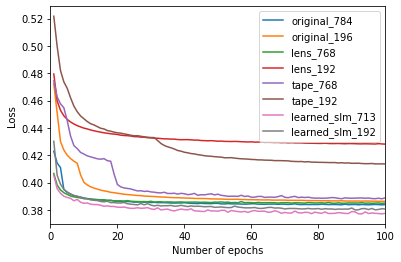

In [31]:
# load and plot error plots
for m in models.keys():
    test_loss = np.load(str(models[m] / "test_loss.npy"))
    n_epoch = np.arange(len(test_loss)) + 1
    print(f"{m} : {np.min(test_loss)}")
    plt.plot(n_epoch,  test_loss, label=m)
plt.legend()
plt.ylabel("Loss")
plt.xlim([0, 100])
plt.xlabel("Number of epochs");

original_784 : 0.9301999807357788
original_196 : 0.9235000014305115
lens_768 : 0.9246000051498413
lens_192 : 0.7554000020027161
tape_768 : 0.9214999675750732
tape_192 : 0.8206999897956848
learned_slm_713 : 0.9535999894142151
learned_slm_192 : 0.9417999982833862


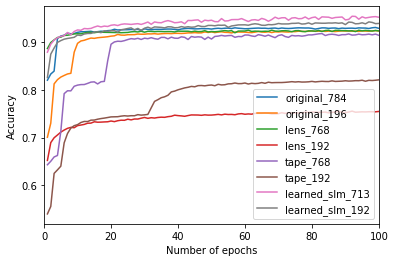

In [32]:
for m in models.keys():
    test_acc = np.load(str(models[m] / "test_acc.npy"))
    n_epoch = np.arange(len(test_acc)) + 1
    print(f"{m} : {np.max(test_acc)}")
    plt.plot(n_epoch,  test_acc, label=m)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Number of epochs")
plt.xlim([0, 100]);
# plt.ylim([0.85, 1])

# Confusion matrix on test set

In [23]:
model_dir = models["lens"]
model_dir = models["tape"]
model_dir = models["original"]
model_dir = models["learned_slm_713"]

In [24]:
# Opening JSON file
f = open(str(model_dir / "metadata.json"))
metadata = json.load(f)
pprint(metadata)

{'batch_size': 200,
 'best_test_acc': 0.9535999894142151,
 'best_test_acc_epoch': 92,
 'dataset': '/home/bezzam/LenslessClassification/data/MNIST_no_psf_down8',
 'mean': 0.0010810066014528275,
 'model': 'SLMMultiClassLogistic',
 'model_param': {'crop_fact': 0.8,
                 'deadspace': True,
                 'device': 'cuda',
                 'device_mask_creation': 'cpu',
                 'dropout': None,
                 'input_shape': [380, 507],
                 'mask2sensor': 0.004,
                 'multi_gpu': True,
                 'output_dim': [23, 31],
                 'scene2mask': 0.4},
 'seed': 0,
 'sensor': 'rpi_hq',
 'sensor_activation': 'relu',
 'slm': 'adafruit',
 'std': 0.02881494164466858}


In [6]:
# load test set
if metadata["dataset"]:
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(metadata["mean"], metadata["std"])])
    test_set = MNISTAugmented(path=metadata["dataset"], train=False, transform=trans)

else:
    root = "../data"
    trans = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((metadata["mean"],), (metadata["std"],))]
    )
    test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=metadata["batch_size"], shuffle=False
)

In [7]:
# create model instance
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("CUDA available, using GPU.")
    device = "cuda"
else:
    device = "cpu"
    print("CUDA not available, using CPU.")

if metadata["model"] == "SLMMultiClassLogistic":
    sensor_act_fn = None
    sensor_act = metadata["sensor_activation"]
    if sensor_act is not None:
        if sensor_act == "relu":
            sensor_act_fn = nn.ReLU()
        elif sensor_act == "leaky":
            sensor_act_fn = nn.LeakyReLU(float=0.1)
        elif sensor_act == "tanh":
            sensor_act_fn = nn.Tanh()
        else:
            raise ValueError("Not supported activation.")

    metadata["model_param"].update(
        {
            "slm_config": slm_dict[metadata["slm"]],
            "sensor_config": sensor_dict[metadata["sensor"]],
            "sensor_activation": sensor_act_fn,
        }
    )
    model = SLMMultiClassLogistic(**metadata["model_param"])
elif metadata["model"] == "MultiClassLogistic":
    model = MultiClassLogistic(**metadata["model_param"])
else:
    raise ValueError("Unsupported model.")

if use_cuda:
    model = model.to(device)

# -- load from state dict
state_dict_fp = str(model_dir / "state_dict.pth")
model.load_state_dict(torch.load(state_dict_fp))

if metadata["model"] == "SLMMultiClassLogistic":
    # recompute PSF for loaded SLM values
    model.compute_intensity_psf()

CUDA available, using GPU.


In [8]:
print("\nModel's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
slm_vals 	 torch.Size([51, 22])
conv_bn.module.weight 	 torch.Size([1])
conv_bn.module.bias 	 torch.Size([1])
conv_bn.module.running_mean 	 torch.Size([1])
conv_bn.module.running_var 	 torch.Size([1])
conv_bn.module.num_batches_tracked 	 torch.Size([])
linear1.module.weight 	 torch.Size([10, 713])
linear1.module.bias 	 torch.Size([10])


In [9]:
criterion = nn.CrossEntropyLoss()

y_pred = []
y_true = []
correct_cnt, running_loss = 0, 0
total_cnt = 0
for x, target in test_loader:

    # get inputs
    if use_cuda:
        x, target = x.cuda(), target.cuda()

    # forward, and compute loss
    out = model(x)
    loss = criterion(out, target)
    pred_label = torch.max(out.data, 1)[1]
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    running_loss += loss.item() / metadata["batch_size"]

    # save prediction and true for confusion matrix
    y_pred.extend(pred_label.data.cpu().numpy()) # Save Prediction
    y_true.extend(target.data.cpu().numpy())

acc = (correct_cnt * 1.0 / total_cnt).item()
print("test loss: {:.6f}, acc: {:.3f}".format( running_loss, acc))
print('Class distribution: %s' % np.bincount(y_true))

test loss: 0.376556, acc: 0.955
Class distribution: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


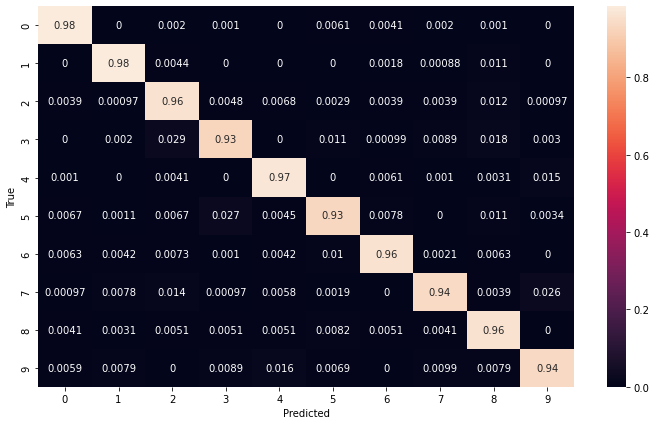

In [10]:
# Build confusion matrix
classes = np.arange(10)
cf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.ylabel("True")
plt.xlabel("Predicted");